In [4]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
words= open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
len(words)

32033

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [39]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [9]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) *87
W2 = torch.randn((n_hidden, vocab_size),          generator=g) *0.01
b2 = torch.randn(vocab_size,                      generator=g) *0

bngain=torch.ones(1,n_hidden)
bnbias=torch.zeros(1,n_hidden)
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

epsilon = 0.00001
parameters=[C,W1,b1,W2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

11870


In [10]:
max_steps=200000
batch_size=32
lossi=[]
for i in range(max_steps):
    
    # minibatch construct 
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix] #batch X,Y
    
    # forward Pass
    emb= C[Xb]
    embcat= emb.view(emb.shape[0],-1)
    hpreact= embcat @ W1 + b1# hidden layer pre-act
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact= bngain*(hpreact-bnmeani)/bnstdi+ bnbias+epsilon #batchnorm

    with torch.no_grad():
        bnmean_running=0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running =0.999*bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # (32, 27)
    loss=F.cross_entropy(logits,Yb)

    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()

    # update
    lr=0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr *p.grad

    # track stats
    if i %10000 ==0: #print every once in a while 
        print(F'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    

    
print(loss.item())

      0/ 200000:3.3147


KeyboardInterrupt: 

In [15]:
@torch.no_grad()
def split_loss(split):
    x,y ={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte),
    }[split]
    emb= C[x]
    embcat= emb.view(emb.shape[0],-1)
    hpreact= embcat @ W1 + b1# hidden layer pre-activation
    #hpreact=bngain*(hpreact-hpreact.mean(0,keepdim=True)/hpreact.std(0,keepdim=True)) + bnbias #batch normalization
    hpreact=bngain*(hpreact-bnmean_running)/bnstd_running + bnbias+epsilon
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # (32, 27)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 3.1508092880249023
val 3.1552674770355225


In [16]:
# train 2.035708427429199
# val 2.1029489040374756

In [17]:
#sample from the model 
g=torch.Generator().manual_seed(2147483647+10)
block_size=5
for _ in range(20):
    out=[]
    context=[0]*block_size
    while True:
        emb=C[torch.tensor([context])]
        h=torch.tanh(emb.view(1,-1)@W1+b1)
        logits=h@W2+b2
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i]for i in out))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x50 and 30x200)

# Pytorchfying

In [61]:
import torch 
import matplotlib.pyplot 
%matplotlib inline

In [235]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [236]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.03%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.00%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.44%


Text(0.5, 1.0, 'activation distribution')

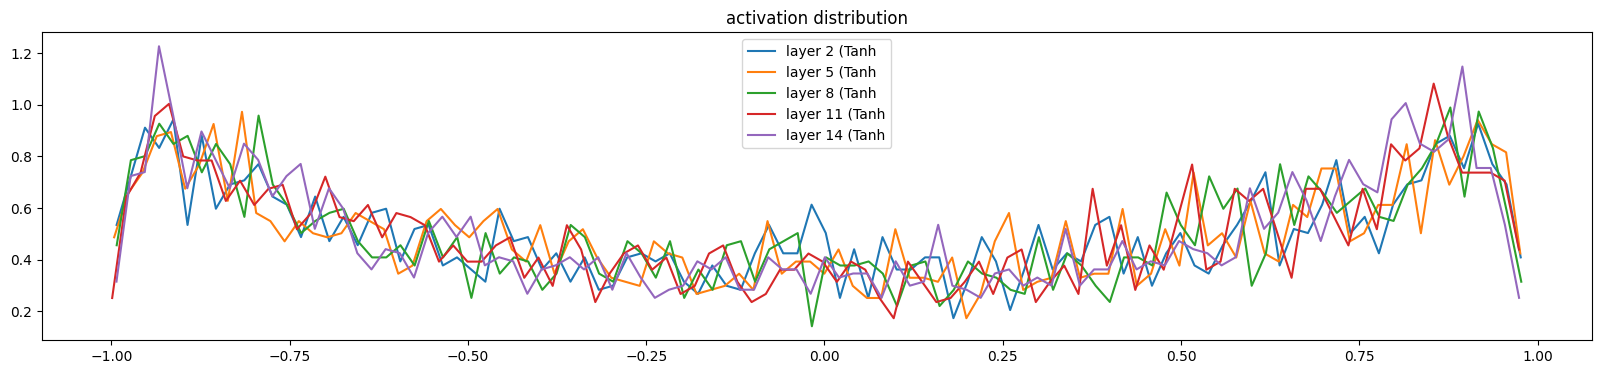

In [237]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.117991e-03
layer 5 (      Tanh): mean +0.000000, std 2.528797e-03
layer 8 (      Tanh): mean -0.000000, std 2.317136e-03
layer 11 (      Tanh): mean -0.000000, std 2.106393e-03
layer 14 (      Tanh): mean +0.000000, std 2.026950e-03


Text(0.5, 1.0, 'gradient distribution')

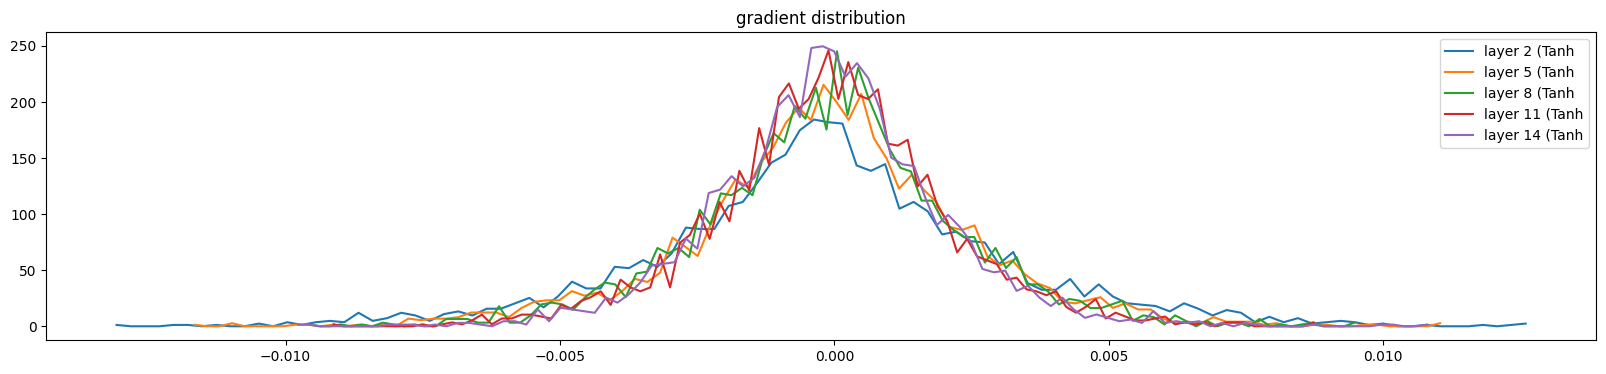

In [238]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')